In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
project_directory = "/content/drive/MyDrive/CryptoSentimentAnalysis"
!mkdir -p {project_directory}
%cd {project_directory}

/content/drive/.shortcut-targets-by-id/1-IfXUhqCn_8KZDK0QhhHZTsgOCSfVHKY/CryptoSentimentAnalysis


# Standard Imports

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf

# Preparation of crawled data

In [ ]:
btc_data = pd.read_csv(f'{project_directory}/btc_tweets.csv')
btc_data

,date,decoded_tweet,id,replyCount,retweetCount,likeCount,quoteCount,conversationId,media,retweetedTweet,quotedTweet,inReplyToTweetId,hashtags,cashtags,user.username,user.verified,user.followersCount,user.friendsCount
0,2021-02-21T23:59:39+00:00,@BTC_JackSparrow @trader1sz punch him again :'D,1363639553949540355,4,0,17,0,1363638621480357894,NaN,NaN,NaN,1.363639e+18,NaN,NaN,inversebrah,False,199431,3043
1,2021-02-21T23:58:17+00:00,ETH performing poorly against btc and fees are...,1363639208011849730,8,1,52,0,1363639208011849730,NaN,NaN,NaN,NaN,NaN,NaN,joshnomics,False,17480,441
2,2021-02-21T23:57:20+00:00,#Bitcoin price at the end of the month?,1363638969414668292,22,0,41,0,1363638969414668292,NaN,NaN,NaN,NaN,['Bitcoin'],NaN,cryptonary,False,80143,199
3,2021-02-21T23:57:14+00:00,Some people believe without Elon $BTC would ha...,1363638944022155264,9,22,242,1,1363638944022155264,NaN,NaN,NaN,NaN,NaN,['BTC'],krugermacro,False,145371,1510
4,2021-02-21T23:50:15+00:00,"FYI at current Hex price, I am getting $100.57...",1363637189834395650,8,6,60,1,1363637189834395650,"[{'_type': 'snscrape.modules.twitter.Gif', 'th...",NaN,NaN,NaN,NaN,NaN,cryptonewbiekid,False,237,179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29152,2021-03-16T00:09:00+00:00,Yep \n\n#Bitcoin has been signaling this for s...,1371614438869065731,11,41,292,0,1371614438869065731,NaN,NaN,NaN,NaN,['Bitcoin'],NaN,maxkeiser,False,484694,902
29153,2021-03-16T00:06:18+00:00,Cannot wait for Xi Jinping to send me $BTC for...,1371613758934634500,4,0,6,0,1371613758934634500,NaN,NaN,NaN,NaN,NaN,['BTC'],BonifaceOption,False,8275,410
29154,2021-03-16T00:04:43+00:00,Bitcoin mining wastes electricity you need to ...,1371613360521904128,3,6,65,1,1371613360521904128,"[{'_type': 'snscrape.modules.twitter.Photo', '...",NaN,NaN,NaN,NaN,NaN,btcfkyou,False,3377,2784
29155,2021-03-16T00:04:01+00:00,@enchiridion47 The fundamental difference betw...,1371613183945932801,3,0,6,1,1371612725353193473,NaN,NaN,NaN,1.371613e+18,NaN,NaN,RokoMijic,False,9188,418


In [ ]:
btc_data.drop_duplicates(subset=['decoded_tweet'], inplace=True)

## Vader labeling

In [ ]:
!pip install vaderSentiment

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 125 kB 37.2 MB/s 


In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

vader = SentimentIntensityAnalyzer()

def apply_vader_on_dataset(dataset_df):
    vader_output = dataset_df.apply(lambda x: pd.Series(vader.polarity_scores(x.decoded_tweet)), axis=1)
    dataset_with_vader = pd.concat([dataset_df, vader_output], axis=1)
    return dataset_with_vader

In [ ]:
btc_data_with_vader = apply_vader_on_dataset(btc_data)

In [ ]:
def undersample_data(df, neg_num, neu_num, pos_num):
    small_df = pd.DataFrame(columns=df.columns)
    df_by_label = {
        "neg": df[df['compound'] <= -0.5],
        "neu": df[(df['compound'] < 0.5) & (df['compound'] > -0.5)],
        "pos": df[df['compound'] >= 0.5]
    }
    print('neg total num: ', df_by_label['neg'].shape[0])
    print('neu total num: ', df_by_label['neu'].shape[0])
    print('pos total num: ', df_by_label['pos'].shape[0])
    small_df = pd.concat([small_df, df_by_label['neg'].iloc[:neg_num]])
    small_df = pd.concat([small_df, df_by_label['neu'].iloc[:neu_num]])
    small_df = pd.concat([small_df, df_by_label['pos'].iloc[:pos_num]])

    print(f"small df size result= {small_df.shape}")
    return small_df

data = undersample_data(btc_data_with_vader, 3000, 3000, 3000)

neg total num:  2664
neu total num:  18872
pos total num:  7556
small df size result= (8664, 22)


In [ ]:
data

,date,decoded_tweet,id,replyCount,retweetCount,likeCount,quoteCount,conversationId,media,retweetedTweet,...,hashtags,cashtags,user.username,user.verified,user.followersCount,user.friendsCount,neg,neu,pos,compound
28,2021-02-21T23:20:35+00:00,@VSoien @michaeljburry He's warning about infl...,1363629721733455874,7,1,30,0,1363627735583629312,NaN,NaN,...,NaN,NaN,Kinvert_Ed,False,96,139,0.142,0.797,0.061,-0.5428
31,2021-02-21T23:18:15+00:00,When Tether blows up this month with their cou...,1363629133801152514,7,4,31,1,1363629133801152514,NaN,NaN,...,NaN,NaN,FinanceLancelot,False,23258,305,0.193,0.766,0.041,-0.8176
33,2021-02-21T23:17:00+00:00,@michaeljburry He warned stocks and bitcoin co...,1363628820058812422,19,3,128,0,1363627735583629312,NaN,NaN,...,NaN,NaN,BeanieBabyTrade,False,330,471,0.121,0.840,0.040,-0.5661
43,2021-02-21T23:11:31+00:00,The real max pain will be crypto OGS selling $...,1363627440518520835,60,96,1628,9,1363627440518520835,NaN,NaN,...,NaN,['BTC'],pythianism,False,61095,3072,0.142,0.858,0.000,-0.5106
80,2021-02-21T22:46:18+00:00,@pierre_rochard A word on Square’s Cash app po...,1363621092984688641,13,1,60,2,1363618847949869057,NaN,NaN,...,NaN,NaN,anurag201320,False,46,585,0.154,0.846,0.000,-0.7476
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12119,2021-03-01T11:46:22+00:00,"""If Gamestop were to turn itself into a 5,000-...",1366354118093250561,18,33,162,5,1366354118093250561,NaN,NaN,...,NaN,NaN,BTCTN,True,2666125,916,0.000,0.881,0.119,0.5859
12121,2021-03-01T11:45:41+00:00,Welcome @kevinolearytv - u in fact did it. 3% ...,1366353947838078989,16,12,181,1,1366353947838078989,NaN,NaN,...,['Bitcoin'],NaN,GoingParabolic,False,204999,422,0.000,0.786,0.214,0.5994
12124,2021-03-01T11:43:22+00:00,Fascinating part is banks are starting to flex...,1366353365098106883,29,39,649,1,1366352878504353794,NaN,NaN,...,NaN,NaN,zhusu,True,568783,1697,0.000,0.857,0.143,0.5423
12126,2021-03-01T11:40:03+00:00,Indians are accustomed to savings and investin...,1366352530574344193,9,31,115,0,1366352530574344193,NaN,NaN,...,NaN,NaN,smtgpt,True,126663,717,0.000,0.812,0.188,0.7506


In [ ]:

def report_data_distribution(data):
    result = {"max": None, "compound": None}
    result['max'] = np.array(np.unique(data[['neg', 'neu', 'pos']].to_numpy().argmax(axis=1), return_counts=True))
    result['compound'] = {
        'neg0': data[data['compound'] <= -0.5].shape[0],
        'neu1': data[(data['compound'] < 0.5) & (data['compound'] > -0.5)].shape[0],
        'pos2': data[data['compound'] >= 0.5].shape[0]
    }
    
    return result

In [ ]:
report_data_distribution(btc_data_with_vader)

{'max': array([[    0,     1,     2],
        [   80, 28879,   133]]),
 'compound': {'neg0': 2664, 'neu1': 18872, 'pos2': 7556}}

# Load raw dataset

## download datasets to drive (run this just once)

upload kaggle config file to kaggle directory in drive

In [ ]:
from google.colab import files
files.upload()
!pip install -q kaggle
!mkdir -p /content/drive/MyDrive/Kaggle
!cp kaggle.json /content/drive/MyDrive/Kaggle/
!chmod 600 /content/drive/MyDrive/Kaggle/kaggle.json

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Kaggle"

!cd /content/drive/MyDrive/Kaggle/
!kaggle datasets download -d fabioturazzi/cryptocurrency-tweets-with-sentiment-analysis -p /content/drive/MyDrive/Kaggle --unzip

## read raw data

In [ ]:
def read_raw_data():
    # load dataset from drive
    tweets_sentiment_df = pd.read_csv('/content/drive/MyDrive/Kaggle/tweets_sentiment.csv',index_col=0, low_memory=False)
    # filter just english tweets
    tweets_sentiment_df = tweets_sentiment_df[tweets_sentiment_df['language']=='en']
    tweets_sentiment_df = tweets_sentiment_df[tweets_sentiment_df['search']=='bitcoin']
    # keep columns that need
    tweets_sentiment_df = tweets_sentiment_df[['date', 'time', 'decoded_tweet', 'neg', 'neu', 'pos', 'compound']]
    # merge data and time column to new date_time column
    tweets_sentiment_df.loc[:,'date_time'] = pd.to_datetime(tweets_sentiment_df.date.astype(str)+' '+tweets_sentiment_df.time.astype(str))
    tweets_sentiment_df.drop(columns=['date', 'time'], inplace=True)
    # change datetime from Pacific Standard Time (PST) to UTC (pst is UTC-8:00)
    tweets_sentiment_df['date_time'] = tweets_sentiment_df['date_time'] + pd.Timedelta(hours=8)
    
    return tweets_sentiment_df

In [ ]:
from tensorflow.keras.utils import to_categorical


def convert_labels_to_one_hot(df, from_compound=False):
    """
    helper function to convert regression labels to one-hot form
  """
    if from_compound:
        df.loc[df['compound'] <= -0.5, 'label'] = 0
        df.loc[(df['compound']<0.5) & (df['compound']>-0.5), 'label'] = 1
        df.loc[df['compound'] >= 0.5, 'label'] = 2
        labels = df['label'].to_numpy()
        df.drop(columns=['label'], inplace=True)
    else:
        labels = df[['neg', 'neu', 'pos']].to_numpy()
        labels = np.argmax(labels, axis=1)
    
    labels = np.array(to_categorical(labels, num_classes=3))
    df.loc[:, ['neg', 'neu', 'pos']] = labels
    
    return df

In [ ]:
def make_dataframe_small(df, neg_num, neu_num, pos_num):
    small_df = pd.DataFrame(columns=df.columns)
    df_by_label = {
        "neg": df[(df['neg'] > df['neu']) & (df['neg'] > df['pos'])],
        "neu": df[(df['neu'] > df['neg']) & (df['neu'] > df['pos'])],
        "pos": df[(df['pos'] > df['neg']) & (df['pos'] > df['neu'])]
    }
    print('neg total num: ', df_by_label['neg'].shape[0])
    print('neu total num: ', df_by_label['neu'].shape[0])
    print('pos total num: ', df_by_label['pos'].shape[0])
    small_df = pd.concat([small_df, df_by_label['neg'].iloc[:neg_num]])
    small_df = pd.concat([small_df, df_by_label['neu'].iloc[:neu_num]])
    small_df = pd.concat([small_df, df_by_label['pos'].iloc[:pos_num]])

    print(f"small df size result= {small_df.shape}")
    return small_df

In [ ]:
def normalize_label_columns(df):
    x = df[['neg', 'neu', 'pos']].to_numpy()
    col_sum = x.sum(axis=1)
    y = np.divide(x, col_sum.reshape((-1, 1)))
    df.loc[:, ['neg', 'neu', 'pos']] = y
    return df


def change_labels_to_balance_dataset_1(raw_data):
    # negative data
    neg_data = raw_data[(raw_data['pos']+0.1 < raw_data['neg']) & (raw_data['neu'] < 2*raw_data['neg'])]  # 3500
    raw_data = pd.concat([raw_data, neg_data]).drop_duplicates(keep=False)
    neg_data.loc[:, ['neg']] = neg_data['neg']*2
    neg_data = normalize_label_columns(neg_data)
    
    # positive data
    pos_data = raw_data[(raw_data['pos'] > raw_data['neg']+0.1) & (raw_data['neu'] <2*raw_data['pos'])].sample(n=4000, random_state=2)
    raw_data = pd.concat([raw_data, pos_data]).drop_duplicates(keep=False)
    pos_data.loc[:, ['pos']] = pos_data['pos']*2
    pos_data = normalize_label_columns(pos_data)
    
    # neutral data
    neu_data = raw_data.sample(n=4000, random_state=42)
    
    small_data = pd.concat([neu_data, pos_data, neg_data])
    return small_data

In [ ]:
def get_data_without_neu_data(raw_data):
    neg_data = raw_data[(raw_data['neg'] > raw_data['pos']) & (raw_data['neg'] > raw_data['neu'])]
    pos_data = raw_data[(raw_data['pos'] > raw_data['neg']) & (raw_data['pos'] > raw_data['neu'])]
    data = pd.concat([neg_data, pos_data])
    return data

In [ ]:
def create_regression_label(raw_data):
    regression_label = raw_data['pos'] - raw_data['neg']
    raw_data['regression_label'] = regression_label
    return raw_data

In [ ]:
raw_data = read_raw_data()
# raw_data = make_dataframe_small(raw_data, 500, 500, 500)
# raw_data = create_regression_label(raw_data)
raw_data = change_labels_to_balance_dataset_1(raw_data)
# raw_data = get_data_without_neu_data(raw_data)
raw_data

NameError: ignored

In [ ]:
df_by_label = {
    "neg": raw_data[(raw_data['neg'] > raw_data['neu']) & (raw_data['neg'] > raw_data['pos'])],
    "neu": raw_data[(raw_data['neu'] > raw_data['neg']) & (raw_data['neu'] > raw_data['pos'])],
    "pos": raw_data[(raw_data['pos'] > raw_data['neg']) & (raw_data['pos'] > raw_data['neu'])]
}
print('neg total num: ', df_by_label['neg'].shape[0])
print('neu total num: ', df_by_label['neu'].shape[0])
print('pos total num: ', df_by_label['pos'].shape[0])

# Preprocess

install packages requirements

In [ ]:
!pip install pyspellchecker

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.5 MB 21.8 MB/s 


definition of preprocess functions on text

In [ ]:
import string
import re
import nltk
import spacy

nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('wordnet')


# Removal of URLs
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)


# Removal of HTML tags
def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)


# Removal of mentions
def remove_mentions(text):
    return re.sub("@[A-Za-z0-9_]+","", text)


# Removal of stopwords
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])


# Stemming
# nothing


# Lemmatization
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])


# Removal of Emojis
def remove_emoji(text):
    emoji_pattern = re.compile("["
                        u"\U0001F600-\U0001F64F"  # emoticons
                        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                        u"\U0001F680-\U0001F6FF"  # transport & map symbols
                        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                        u"\U00002702-\U000027B0"
                        u"\U000024C2-\U0001F251"
                        "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


# Removal of emoticons
# todo: nothing


# Conversion of emoticons to words
# todo: nothing


# Conversion of emojis to words
# todo: nothing


# Chat Words Conversion
chat_words_str = """
AFAIK=As Far As I Know
AFK=Away From Keyboard
ASAP=As Soon As Possible
ATK=At The Keyboard
ATM=At The Moment
A3=Anytime, Anywhere, Anyplace
BAK=Back At Keyboard
BBL=Be Back Later
BBS=Be Back Soon
BFN=Bye For Now
B4N=Bye For Now
BRB=Be Right Back
BRT=Be Right There
BTW=By The Way
B4=Before
B4N=Bye For Now
CU=See You
CUL8R=See You Later
CYA=See You
FAQ=Frequently Asked Questions
FC=Fingers Crossed
FWIW=For What It's Worth
FYI=For Your Information
GAL=Get A Life
GG=Good Game
GN=Good Night
GMTA=Great Minds Think Alike
GR8=Great!
G9=Genius
IC=I See
ICQ=I Seek you (also a chat program)
ILU=ILU: I Love You
IMHO=In My Honest/Humble Opinion
IMO=In My Opinion
IOW=In Other Words
IRL=In Real Life
KISS=Keep It Simple, Stupid
LDR=Long Distance Relationship
LMAO=Laugh My A.. Off
LOL=Laughing Out Loud
LTNS=Long Time No See
L8R=Later
MTE=My Thoughts Exactly
M8=Mate
NRN=No Reply Necessary
OIC=Oh I See
PITA=Pain In The A..
PRT=Party
PRW=Parents Are Watching
ROFL=Rolling On The Floor Laughing
ROFLOL=Rolling On The Floor Laughing Out Loud
ROTFLMAO=Rolling On The Floor Laughing My A.. Off
SK8=Skate
STATS=Your sex and age
ASL=Age, Sex, Location
THX=Thank You
TTFN=Ta-Ta For Now!
TTYL=Talk To You Later
U=You
U2=You Too
U4E=Yours For Ever
WB=Welcome Back
WTF=What The F...
WTG=Way To Go!
WUF=Where Are You From?
W8=Wait...
7K=Sick:-D Laugher
"""

chat_words_map_dict = {}
chat_words_list = []
for line in chat_words_str.split("\n"):
    if line != "":
        cw = line.split("=")[0]
        cw_expanded = line.split("=")[1]
        chat_words_list.append(cw)
        chat_words_map_dict[cw] = cw_expanded
chat_words_list = set(chat_words_list)

def chat_words_conversion(text):
    new_text = []
    for w in text.split():
        if w.upper() in chat_words_list:
            new_text.append(chat_words_map_dict[w.upper()])
        else:
            new_text.append(w)
    return " ".join(new_text)


# Spelling Correction
from spellchecker import SpellChecker

spell = SpellChecker()
def correct_spellings(text):
    """ its norving method """
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)


# Removal of numbers 
def remove_number(text):
    return re.sub("[0-9]+", "", text)


# Removal of Punctuations
PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))


# remove over spaces
def remove_over_spaces(text):
    return re.sub('\s{2,}', " ", text)


[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
# symspell method for spell correction that is fast but is not so good
# in some case it make words incorrect

# import pkg_resources
# from symspellpy import SymSpell

# sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
# dictionary_path = pkg_resources.resource_filename(
#     "symspellpy", "frequency_dictionary_en_82_765.txt"
# )
# bigram_path = pkg_resources.resource_filename(
#     "symspellpy", "frequency_bigramdictionary_en_243_342.txt"
# )

# # term_index is the column of the term and count_index is the
# # column of the term frequency
# sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)
# sym_spell.load_bigram_dictionary(bigram_path, term_index=0, count_index=2)

# def correct_spellings_symspell(text):
#     # max edit distance per lookup (per single word, not per whole input string)
#     suggestions = sym_spell.lookup_compound(text, max_edit_distance=2)
#     # display suggestion term, edit distance, and term frequency
    
#     return suggestions[0].term

# x = correct_spellings_symspell("my haert noooooo")
# print(x)

preprocess on raw data

In [ ]:
def preprocess(
    raw_data_df,
    save_csv=False,
    save_path=None,
    urls=True,
    htmls=True,
    mentions=True,
    stop_words=True,
    lemmatize=True,
    emoji=True,
    chat_abbreviations=True,
    spell_correction=True,
    numbers=True,
    punctuations=True,
    over_space=True):
    '''
    preprocess raw data that is in dataframe form
    there are some flags to determine preprocess actions
    '''
    clean_tweets = raw_data_df['decoded_tweet']
    clean_tweets = clean_tweets.str.lower()  # lower casing

    if urls: 
        print("-> urls"); clean_tweets = clean_tweets.apply(lambda text: remove_urls(text))

    if htmls: 
        print("-> htmls"); clean_tweets = clean_tweets.apply(lambda text: remove_html(text))

    if mentions:
        print("-> mentions"); clean_tweets = clean_tweets.apply(lambda text: remove_mentions(text))

    if stop_words:
        print("-> stop words"); clean_tweets = clean_tweets.apply(lambda text: remove_stopwords(text))

    if lemmatize:
        print("-> lemmatize"); clean_tweets = clean_tweets.apply(lambda text: lemmatize_words(text))

    if emoji: 
        print("-> emoji"); clean_tweets = clean_tweets.apply(lambda text: remove_emoji(text))

    if chat_abbreviations: 
        print("-> chat abbreviations"); clean_tweets = clean_tweets.apply(lambda text: chat_words_conversion(text))
    
    if spell_correction: 
        print("-> spell correciton"); clean_tweets = clean_tweets.apply(lambda text: correct_spellings(text))
    
    if numbers: 
        print("-> numbers"); clean_tweets = clean_tweets.apply(lambda text: remove_number(text))
    
    if punctuations: 
        print("-> punctuations"); clean_tweets = clean_tweets.apply(lambda text: remove_punctuation(text))
    clean_tweets = clean_tweets.str.lower()
    
    if over_space: 
        print("-> over space"); clean_tweets = clean_tweets.apply(lambda text: remove_over_spaces(text))

    raw_data_df['clean_tweet'] = clean_tweets

    # save preprocessed data to drive in csv format
    if save_csv:
        raw_data_df.to_csv(save_path, index=False)

    return raw_data_df

In [ ]:
pproc_data = preprocess(small_raw_data, save_csv=True, save_path="data_3000_pproc_yesSpell.csv")

-> urls
-> htmls
-> mentions
-> stop words
-> lemmatize
-> emoji
-> chat abbreviations
-> spell correciton
-> numbers
-> punctuations
-> over space


In [ ]:
pproc_data = preprocess(
    data, save_csv=True, spell_correction=False, save_path="crawled_data_pproc_noSpell.csv"
)

-> urls
-> htmls
-> mentions
-> stop words
-> lemmatize
-> emoji
-> chat abbreviations
-> numbers
-> punctuations
-> over space


# Preparation of preprocessed dataset and embedding layer

## load preprocessed data

In [ ]:
!ls

btc.csv				    logs
btc_tweets.csv			    models
change_label_11K_pproc_noSpell.csv  undersample_1500_pproc_noSpell.csv
crawled_data_pproc_noSpell.csv	    without_neu_1600_pproc_noSpell.csv
glove.twitter.27B.200d.txt	    without_neu_7500_pproc_noSpell.csv


In [ ]:
def load_preprocessed_data(path, label_type='default', from_compound=False):
    """
    label_type: 'default' or 'regression' or 'one-hot'
    """
    df = pd.read_csv(path)
    if from_compound:
        df = df[['compound', 'clean_tweet']]
        df = df.astype({'compound': 'float', 'clean_tweet': 'str'})
    else:
        df = df[['neg', 'neu', 'pos', 'clean_tweet']]
        df = df.astype({'neg': 'float', 'neu': 'float', 'pos': 'float', 'clean_tweet': 'str'})

    if label_type == 'one-hot':
        df = convert_labels_to_one_hot(df, from_compound)
    elif label_type == 'regression':
        df = create_regression_label(df, from_compound)

    return df


df = load_preprocessed_data(
    path=f'{project_directory}/crawled_data_pproc_noSpell.csv',
    label_type='one-hot',
    from_compound=True
)
display(df)

,compound,clean_tweet,neg,neu,pos
0,-0.5428,hes warning inflation societal collapse lot th...,1.0,0.0,0.0
1,-0.8176,tether blow month court order bitcoin also im ...,1.0,0.0,0.0
2,-0.5661,warned stock bitcoin could go down massive inf...,1.0,0.0,0.0
3,-0.5106,real max pain crypto ogs selling btc k watchin...,1.0,0.0,0.0
4,-0.7476,word square’s cash app policies severely throt...,1.0,0.0,0.0
...,...,...,...,...,...
8659,0.5859,if gamestop turn store introduction crypto mak...,0.0,0.0,1.0
8660,0.5994,welcome you fact it net worth bitcoin next ste...,0.0,0.0,1.0
8661,0.5423,fascinating part bank starting flex early rese...,0.0,0.0,1.0
8662,0.7506,indian accustomed saving investing store value...,0.0,0.0,1.0


## Constants Definition

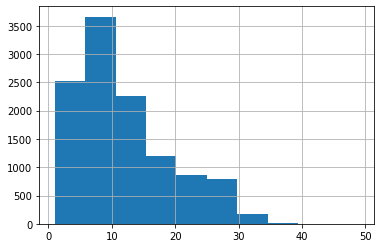

In [ ]:
lengths = df['clean_tweet'].apply(lambda tweet: len(tweet.split()))
lengths.hist()
plt.show()

In [ ]:
# Dimensions of the embeddings
# notice: this variable use for load glove pretrianed word embedding
N_EMB = 200

# Fraction of samples to be used for training set
N_TRAIN = 0.8

# Size of each sequence to be embedded:
N_SEQ = 128 # Chosen based on the histogram of the lengths

# Size of vocabulary
N_vocab = None  # This will be valued later in code

## Split Dataset

In [ ]:
from sklearn.model_selection import train_test_split as tts

df_train, df_val = tts(df, train_size=N_TRAIN, shuffle=True, random_state=42)

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6931 entries, 6205 to 7270
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   compound     6931 non-null   float64
 1   clean_tweet  6931 non-null   object 
 2   neg          6931 non-null   float64
 3   neu          6931 non-null   float64
 4   pos          6931 non-null   float64
dtypes: float64(4), object(1)
memory usage: 324.9+ KB


## Word index like a vocabulary

In [ ]:
from keras.preprocessing.text import Tokenizer

tok = Tokenizer()
tok.fit_on_texts(df["clean_tweet"])  # to create word_index
word_index = tok.word_index
N_vocab = len(tok.word_index) + 1
print(N_vocab)

15682


In [ ]:
from keras.preprocessing.sequence import pad_sequences


def create_dataset(regression_mode=False):
    x_train = pad_sequences(
        tok.texts_to_sequences(df_train["clean_tweet"]), maxlen=N_SEQ, padding='post', truncating='post', dtype=int
    )
    x_val   = pad_sequences(
        tok.texts_to_sequences(df_val["clean_tweet"]), maxlen=N_SEQ, padding='post', truncating='post', dtype=int
    )

    if not regression_mode:
        y_train = df_train[['neg','neu', 'pos']].to_numpy(dtype=float)
        y_val = df_val[['neg','neu', 'pos']].to_numpy(dtype=float)
    else:
        y_train = df_train[['regression_label']].to_numpy(dtype=float)
        y_val = df_val[['regression_label']].to_numpy(dtype=float)

    return (x_train, y_train), (x_val, y_val)


(x_train, y_train), (x_val, y_val) = create_dataset(regression_mode=False)

print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_val: ", x_val.shape)
print("y_val: ", y_val.shape)

x_train:  (6931, 128)
y_train:  (6931, 3)
x_val:  (1733, 128)
y_val:  (1733, 3)


In [ ]:
print(x_train[0])
print(y_train[0])

[ 2369 13018   749  6504   916  1091  1084     2   122   902   213   192
   128 13019   475     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]
[0. 0. 1.]


## Preparing the Embedding layer

In [ ]:
!ls

change_label_11K_pproc_noSpell.csv


In [ ]:
!wget https://nlp.stanford.edu/data/glove.twitter.27B.zip
!unzip glove.twitter.27B.zip

--2022-07-11 09:14:51--  https://nlp.stanford.edu/data/glove.twitter.27B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip [following]
--2022-07-11 09:14:52--  https://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1520408563 (1.4G) [application/zip]
Saving to: ‘glove.twitter.27B.zip’

glove.twitter.27B.z 100%[===================>]   1.42G  5.08MB/s    in 4m 45s  

2022-07-11 09:19:37 (5.09 MB/s) - ‘glove.twitter.27B.zip’ saved [1520408563/1520408563]

Archive:  glove.twitter.27B.zip
  inflating: glove.twitter.27

In [ ]:
embedding_path = f"./glove.twitter.27B.{N_EMB}d.txt"

def get_word2vec(file_path):
    with open(file_path, "r") as f:
        word2vec = dict()
        for line in f:
            word, coefs = line.split(maxsplit=1)
            coefs = np.fromstring(coefs, "f", sep=" ")
            word2vec[word] = coefs
    
    return (word2vec)

w2v = get_word2vec(embedding_path)

In [ ]:
embedding_matrix = np.zeros((N_vocab, N_EMB))
for word, i in word_index.items():
    embedding_vector = w2v.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Model

In [ ]:
from keras.models import Sequential, load_model
from keras import layers
from keras import initializers
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers
from keras import losses
from keras import metrics
import sklearn

In [ ]:
N_BATCH = 32
N_EPOCHS = 40

## Simple Model (model_2l)
- 2 BiLSTM layer

In [ ]:
def build_model_2l(optimizer, loss, checkpoint_filepath, metrics, regression_mode=False):
    model = Sequential()
    model.add(layers.Embedding(
        input_dim=N_vocab,
        output_dim=N_EMB,
        embeddings_initializer=initializers.Constant(embedding_matrix),
        input_length=N_SEQ,
        trainable=True))
    model.add(layers.Bidirectional(layers.LSTM(60, return_sequences=True)))
    model.add(layers.Bidirectional(layers.LSTM(20)))
    if not regression_mode:
        model.add(layers.Dense(3, activation='softmax'))
    else:
        model.add(layers.Dense(1, activation='tanh'))

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=metrics
    )

    checkpoint = ModelCheckpoint(
        filepath=checkpoint_filepath, monitor='val_mean_absolute_error', verbose=1,
        save_best_only=True, mode='auto', save_freq="epoch", save_weights_only=True
    )

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_mean_absolute_error', mode='min', verbose=1, patience=6
    )

    return model, checkpoint, early_stopping


build and train simple model

In [ ]:
model_2l, checkpoint, early_stopping = build_model_2l(
    optimizer=optimizers.Adam(learning_rate=2e-5),
    loss=losses.CategoricalCrossentropy(),  # losses.MeanAbsoluteError() - losses.CategoricalCrossentropy()
    checkpoint_filepath="model.hdf5",
    metrics=[metrics.CategoricalAccuracy()],
    regression_mode=False
)
model_2l.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 128, 200)          3136400   
                                                                 
 bidirectional_22 (Bidirecti  (None, 128, 120)         125280    
 onal)                                                           
                                                                 
 bidirectional_23 (Bidirecti  (None, 40)               22560     
 onal)                                                           
                                                                 
 dense_5 (Dense)             (None, 3)                 123       
                                                                 
Total params: 3,284,363
Trainable params: 3,284,363
Non-trainable params: 0
_________________________________________________________________


In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs/model2l/crawled/8500")
history = model_2l.fit(
    x_train, y_train, epochs=N_EPOCHS, batch_size=N_BATCH, validation_data=(x_val, y_val),
    callbacks=[tensorboard_callback]
)

Epoch 1/40
217/217 [==============================] - 12s 32ms/step - loss: 1.0887 - categorical_accuracy: 0.4085 - val_loss: 1.0799 - val_categorical_accuracy: 0.4426
Epoch 2/40
217/217 [==============================] - 6s 26ms/step - loss: 1.0680 - categorical_accuracy: 0.4660 - val_loss: 1.0605 - val_categorical_accuracy: 0.4743
Epoch 3/40
217/217 [==============================] - 5s 25ms/step - loss: 1.0437 - categorical_accuracy: 0.5077 - val_loss: 1.0349 - val_categorical_accuracy: 0.5014
Epoch 4/40
217/217 [==============================] - 6s 26ms/step - loss: 1.0101 - categorical_accuracy: 0.5344 - val_loss: 1.0004 - val_categorical_accuracy: 0.5326
Epoch 5/40
217/217 [==============================] - 6s 26ms/step - loss: 0.9640 - categorical_accuracy: 0.5734 - val_loss: 0.9544 - val_categorical_accuracy: 0.5684
Epoch 6/40
217/217 [==============================] - 6s 26ms/step - loss: 0.9087 - categorical_accuracy: 0.6070 - val_loss: 0.9112 - val_categorical_accuracy: 0.59

## Model (model_4l)
 
*    4 BiLSTM layer
*    untis: 128,64,32,20

In [ ]:
def build_model_4l(optimizer, loss, checkpoint_filepath, metrics, regression_mode=False):
    model = Sequential()
    model.add(layers.Embedding(
        input_dim=N_vocab,
        output_dim=N_EMB,
        embeddings_initializer=initializers.Constant(embedding_matrix),
        input_length=N_SEQ,
        trainable=True))
    # model.add(layers.Bidirectional(layers.LSTM(320, return_sequences=True)))
    # model.add(layers.Bidirectional(layers.LSTM(288, return_sequences=True)))  #kernel_regularizer=regularizers.L1()
    # model.add(layers.Bidirectional(layers.LSTM(256, return_sequences=True)))
    # model.add(layers.Bidirectional(layers.LSTM(224, return_sequences=True)))  #, kernel_regularizer=regularizers.L1()
    # model.add(layers.Bidirectional(layers.LSTM(192, return_sequences=True)))
    # model.add(layers.Bidirectional(layers.LSTM(160, return_sequences=True)))  #, kernel_regularizer=regularizers.L1()
    model.add(layers.Bidirectional(layers.LSTM(128, return_sequences=True)))
    model.add(layers.Bidirectional(layers.LSTM(64, return_sequences=True)))
    model.add(layers.Bidirectional(layers.LSTM(32, return_sequences=True)))
    model.add(layers.Bidirectional(layers.LSTM(20)))
    if not regression_mode:
        model.add(layers.Dense(3, activation='softmax'))
    else:
        model.add(layers.Dense(1, activation='tanh'))

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=metrics
    )

    checkpoint = ModelCheckpoint(        
        filepath=checkpoint_filepath, monitor='val_mean_absolute_error', verbose=1,
        save_best_only=True, mode='auto', save_freq="epoch", save_weights_only=True
    )

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_mean_absolute_error', mode='min', verbose=1, patience=4
    )

    return model, checkpoint, early_stopping

In [ ]:
model_4l, checkpoint, early_stopping = build_model_4l(
    optimizer=optimizers.Adam(learning_rate=2e-5),
    loss=losses.CategoricalCrossentropy(),  # losses.MeanAbsoluteError() - losses.CategoricalCrossentropy()
    checkpoint_filepath="model.hdf5",
    metrics=[metrics.CategoricalAccuracy()],
    regression_mode=False
)
model_4l.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 128, 200)          3136400   
                                                                 
 bidirectional_24 (Bidirecti  (None, 128, 256)         336896    
 onal)                                                           
                                                                 
 bidirectional_25 (Bidirecti  (None, 128, 128)         164352    
 onal)                                                           
                                                                 
 bidirectional_26 (Bidirecti  (None, 128, 64)          41216     
 onal)                                                           
                                                                 
 bidirectional_27 (Bidirecti  (None, 40)               13600     
 onal)                                                

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs/model4l/crawled/8500")
history = model_4l.fit(
    x_train, y_train, epochs=N_EPOCHS, batch_size=N_BATCH, validation_data=(x_val, y_val),
    callbacks=[tensorboard_callback]
)

Epoch 1/40
217/217 [==============================] - 25s 63ms/step - loss: 1.0841 - categorical_accuracy: 0.4047 - val_loss: 1.0674 - val_categorical_accuracy: 0.4789
Epoch 2/40
217/217 [==============================] - 11s 51ms/step - loss: 1.0274 - categorical_accuracy: 0.5441 - val_loss: 0.9850 - val_categorical_accuracy: 0.5713
Epoch 3/40
217/217 [==============================] - 11s 53ms/step - loss: 0.9323 - categorical_accuracy: 0.6042 - val_loss: 0.9153 - val_categorical_accuracy: 0.6151
Epoch 4/40
217/217 [==============================] - 12s 53ms/step - loss: 0.8721 - categorical_accuracy: 0.6317 - val_loss: 0.8804 - val_categorical_accuracy: 0.6330
Epoch 5/40
217/217 [==============================] - 12s 53ms/step - loss: 0.8331 - categorical_accuracy: 0.6510 - val_loss: 0.8543 - val_categorical_accuracy: 0.6411
Epoch 6/40
217/217 [==============================] - 12s 53ms/step - loss: 0.7991 - categorical_accuracy: 0.6700 - val_loss: 0.8350 - val_categorical_accuracy:

## Complex Model (model_10l)

In [ ]:
def build_model_10l(optimizer, loss, checkpoint_filepath):
    model = Sequential()
    model.add(layers.Embedding(
        input_dim=N_vocab,
        output_dim=N_EMB,
        embeddings_initializer=initializers.Constant(embedding_matrix),
        input_length=N_SEQ,
        trainable=True))
    model.add(layers.Bidirectional(layers.LSTM(320, return_sequences=True)))
    model.add(layers.Bidirectional(layers.LSTM(288, return_sequences=True)))  #kernel_regularizer=regularizers.L1()
    model.add(layers.Bidirectional(layers.LSTM(256, return_sequences=True)))
    model.add(layers.Bidirectional(layers.LSTM(224, return_sequences=True)))  #, kernel_regularizer=regularizers.L1()
    model.add(layers.Bidirectional(layers.LSTM(192, return_sequences=True)))
    model.add(layers.Bidirectional(layers.LSTM(160, return_sequences=True)))  #, kernel_regularizer=regularizers.L1()
    model.add(layers.Bidirectional(layers.LSTM(128, return_sequences=True)))
    model.add(layers.Bidirectional(layers.LSTM(64, return_sequences=True)))  #, kernel_regularizer=regularizers.L1()
    model.add(layers.Bidirectional(layers.LSTM(32, return_sequences=True)))
    model.add(layers.Bidirectional(layers.LSTM(20)))
    model.add(layers.Dense(3,activation='softmax'))

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=[metrics.CategoricalAccuracy()]
    )

    checkpoint = ModelCheckpoint(        
        filepath=checkpoint_filepath, monitor='val_mean_absolute_error', verbose=1,
        save_best_only=True, mode='auto', save_freq="epoch", save_weights_only=True
    )

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_mean_absolute_error', mode='min', verbose=1, patience=4
    )

    return model, checkpoint, early_stopping


In [ ]:
model_10l, checkpoint, early_stopping = build_model_10l(
    optimizer=optimizers.Adam(learning_rate=2e-5),
    loss=losses.CategoricalCrossentropy(),
    checkpoint_filepath="model2_balance_30K_noSpell_model.hdf5"
)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs/model10l/crawled/8500")
history = model_10l.fit(
    x_train, y_train, epochs=N_EPOCHS, batch_size=N_BATCH, validation_data=(x_val, y_val),
    callbacks=[tensorboard_callback]
)

Epoch 1/40
217/217 [==============================] - 71s 205ms/step - loss: 0.9851 - categorical_accuracy: 0.5201 - val_loss: 0.8860 - val_categorical_accuracy: 0.6168
Epoch 2/40
217/217 [==============================] - 37s 170ms/step - loss: 0.8453 - categorical_accuracy: 0.6409 - val_loss: 0.8677 - val_categorical_accuracy: 0.6168
Epoch 3/40
217/217 [==============================] - 39s 178ms/step - loss: 0.7972 - categorical_accuracy: 0.6674 - val_loss: 0.8274 - val_categorical_accuracy: 0.6365
Epoch 4/40
217/217 [==============================] - 37s 170ms/step - loss: 0.7592 - categorical_accuracy: 0.6889 - val_loss: 0.8015 - val_categorical_accuracy: 0.6636
Epoch 5/40
217/217 [==============================] - 39s 178ms/step - loss: 0.7239 - categorical_accuracy: 0.7057 - val_loss: 0.7785 - val_categorical_accuracy: 0.6619
Epoch 6/40
217/217 [==============================] - 39s 179ms/step - loss: 0.6958 - categorical_accuracy: 0.7253 - val_loss: 0.7704 - val_categorical_acc

# BERT model

## Install TensorFlow and TensorFlow Model Garden

In [ ]:
print(tf.version.VERSION)

2.8.2


In [ ]:
!git clone --depth 1 -b v2.8.0 https://github.com/tensorflow/models.git

fatal: destination path 'models' already exists and is not an empty directory.


In [ ]:
# install requirements to use tensorflow/models repository
!pip install -Uqr models/official/requirements.txt
# you may have to restart the runtime afterwards, also ignore any ERRORS popping up at this step

     |████████████████████████████████| 9.0 MB 5.1 MB/s 
     |████████████████████████████████| 281 kB 70.0 MB/s 
     |████████████████████████████████| 99 kB 9.8 MB/s 
     |████████████████████████████████| 238 kB 64.4 MB/s 
     |████████████████████████████████| 1.1 MB 53.0 MB/s 
     |████████████████████████████████| 352 kB 70.0 MB/s 
     |████████████████████████████████| 11.2 MB 45.4 MB/s 
     |████████████████████████████████| 636 kB 68.1 MB/s 
     |████████████████████████████████| 3.1 MB 55.4 MB/s 
     |████████████████████████████████| 43 kB 2.3 MB/s 
     |████████████████████████████████| 1.3 MB 62.1 MB/s 
     |████████████████████████████████| 116 kB 71.6 MB/s 
     |████████████████████████████████| 957 kB 67.5 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.9.0 requires jedi>=0.10, which is not installed.
earthengine-api 

In [ ]:
!pip install tensorflow-text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.6 MB 38.0 MB/s 
     |████████████████████████████████| 511.8 MB 9.0 kB/s 
     |████████████████████████████████| 438 kB 59.6 MB/s 
     |████████████████████████████████| 5.8 MB 55.6 MB/s 
     |████████████████████████████████| 1.6 MB 52.4 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Unins

**Restart the Runtime**

## imports

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import sys
sys.path.append('models')
from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
from official.nlp import optimization
import tensorflow_text as text

In [ ]:
print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

TF Version:  2.9.2
Eager mode:  True
Hub version:  0.12.0
GPU is available


## config

In [ ]:
# Fraction of samples to be used for training set
N_TRAIN = 0.8

N_EPOCHS = 20

## split and taming the data
data split to train and validation and data should be tf.data.Datasets to use in bert model

In [ ]:
from sklearn.model_selection import train_test_split


def create_dataset(data_df, labels_type='default', from_compound=False):
    """
    labels_type: 'default' or 'regression' or 'one-hot'
    """
    if labels_type == 'one-hot':
        data_df = convert_labels_to_one_hot(data_df, from_compound)
    elif labels_type == 'regression':
        data_df = create_regression_label(data_df)
    
    train_df, val_df = train_test_split(data_df, train_size=N_TRAIN, shuffle=True, random_state=42)
    
    if labels_type == 'one-hot':
        train_data = tf.data.Dataset.from_tensor_slices((train_df['decoded_tweet'].values, train_df[['neg', 'neu', 'pos']].values))
        val_data = tf.data.Dataset.from_tensor_slices((val_df['decoded_tweet'].values, val_df[['neg', 'neu', 'pos']].values))
    elif labels_type == 'regression':
        train_data = tf.data.Dataset.from_tensor_slices((train_df['decoded_tweet'].values, train_df[['regression_label']].values))
        val_data = tf.data.Dataset.from_tensor_slices((val_df['decoded_tweet'].values, val_df[['regression_label']].values))

    return train_data, val_data


train_data, val_data = create_dataset(data, labels_type='one-hot', from_compound=True)


# lets look at 1 sample from train set
for text,label in train_data.take(1):
    print(text)
    print(label)

tf.Tensor(b"$VGX $BQX Quite impressed with today's performance despite $BTC correction.\n\nSTRENGTH.\n\nRemember to always HOLD a moonbag. In @Ehrls15 we TRUST.", shape=(), dtype=string)
tf.Tensor([0. 0. 1.], shape=(3,), dtype=float64)


## Download pre-trained BERT model from tensorflow hub

In [ ]:
# Get BERT layer and tokenizer
bert_layer = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
tokenizer = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

In [ ]:
with tf.device('/cpu:0'):
    # train
    train_data = train_data.shuffle(1000).batch(32, drop_remainder = True).prefetch(tf.data.experimental.AUTOTUNE)

    # valid
    val_data = val_data.batch(32, drop_remainder = True).prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
train_data.element_spec

(TensorSpec(shape=(32,), dtype=tf.string, name=None),
 TensorSpec(shape=(32, 3), dtype=tf.float64, name=None))

In [ ]:
# valid data spec
val_data.element_spec

(TensorSpec(shape=(32,), dtype=tf.string, name=None),
 TensorSpec(shape=(32, 3), dtype=tf.float64, name=None))

In [ ]:
# Building the model
def create_model(regression_mode=False):
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='inputs')

    # preprocessing
    preprocessor = hub.KerasLayer(tokenizer)
    encoder_inputs = preprocessor(text_input)

    # passing the encoded inputs to bert model
    encoder = hub.KerasLayer(bert_layer, trainable=True, name='BERT_Encoder')
    outputs = encoder(encoder_inputs)

    # get the pooled outputs
    pooled_output = outputs['pooled_output']

    # add output layer
    # batch_norm = tf.keras.layers.BatchNormalization()(pooled_output)
    # drop = tf.keras.layers.Dropout(0.4)(batch_norm)
    # fc = tf.keras.layers.Dense(128, activation='tanh')(drop)
    if not regression_mode:
        final_output = tf.keras.layers.Dense(3, activation='softmax', name='classifier')(pooled_output)
    else:
        final_output = tf.keras.layers.Dense(1, activation='tanh', name='regression')(pooled_output)

    return tf.keras.Model(text_input, final_output)

In [ ]:
model = create_model(regression_mode=False)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5), 
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy()]
)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None,)]            0           []                               
                                                                                                  
 keras_layer_1 (KerasLayer)     {'input_word_ids':   0           ['inputs[0][0]']                 
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                                

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs/bert/base/one-hot/crawled/8500")

history = model.fit(
    train_data, validation_data=val_data, epochs=N_EPOCHS,
    callbacks=[tensorboard_callback]
)

Epoch 1/20
216/216 [==============================] - 218s 936ms/step - loss: 0.8097 - categorical_accuracy: 0.6317 - val_loss: 0.6261 - val_categorical_accuracy: 0.7581
Epoch 2/20
216/216 [==============================] - 203s 939ms/step - loss: 0.4687 - categorical_accuracy: 0.8111 - val_loss: 0.5390 - val_categorical_accuracy: 0.7760
Epoch 3/20
216/216 [==============================] - 202s 937ms/step - loss: 0.2880 - categorical_accuracy: 0.8861 - val_loss: 0.5777 - val_categorical_accuracy: 0.7963
Epoch 4/20
216/216 [==============================] - 202s 937ms/step - loss: 0.1762 - categorical_accuracy: 0.9363 - val_loss: 0.6462 - val_categorical_accuracy: 0.7986
Epoch 5/20
216/216 [==============================] - 203s 938ms/step - loss: 0.1038 - categorical_accuracy: 0.9672 - val_loss: 0.7946 - val_categorical_accuracy: 0.7818
Epoch 6/20
216/216 [==============================] - 202s 938ms/step - loss: 0.0695 - categorical_accuracy: 0.9771 - val_loss: 0.8491 - val_categoric

# FinBert model
fine-tune finbert model that is bert base and pretrained on financial data

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 5.9 MB/s 
     |████████████████████████████████| 120 kB 39.1 MB/s 
     |████████████████████████████████| 6.6 MB 57.6 MB/s 


In [ ]:
from transformers import TFBertTokenizer, TFBertForSequenceClassification, TFBertModel
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import DataCollatorWithPadding

In [ ]:
tokenizer = TFBertTokenizer.from_pretrained('ProsusAI/finbert')   # yiyanghkust/finbert-tone  -  ProsusAI/finbert - yiyanghkust/finbert-pretrain
finbert = TFBertModel.from_pretrained('ProsusAI/finbert')

# bert-base-uncased 256 -> 90,89
# bert-base-uncased 128 -> 92

# ProsusAI/finbert 256 -> 91
# ProsusAI/finbert 128 -> 90

# yiyanghkust/finbert-pretrain -> acc=86%
# yiyanghkust/finbert-tone -> 86

# tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
# model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert", num_labels=3)

All model checkpoint layers were used when initializing TFBertModel.

All the layers of TFBertModel were initialized from the model checkpoint at ProsusAI/finbert.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
N_TRAIN = 0.8
N_EPOCHS = 20
N_SEQ = 128
N_BATCH = 32

In [ ]:
from sklearn.model_selection import train_test_split

def create_transformers_bert_base_dataset(data_df, from_compound):
    data_df = convert_labels_to_one_hot(data_df, from_compound)
    
    train_df, val_df = train_test_split(data_df, train_size=N_TRAIN, shuffle=True, random_state=42)

    x_train = tokenizer(
        text=train_df.decoded_tweet.tolist(),
        truncation=True,
        max_length=N_SEQ,
        padding='max_length')

    x_val = tokenizer(
        text=val_df.decoded_tweet.tolist(),
        truncation=True,
        max_length=N_SEQ,
        padding='max_length')

    y_train = train_df[['neg', 'neu', 'pos']].to_numpy()
    y_val = val_df[['neg', 'neu', 'pos']].to_numpy()

    train_data = tf.data.Dataset.from_tensor_slices((
        dict({"attention_mask": x_train['attention_mask'], "input_ids": x_train["input_ids"]}),
        y_train
    ))
    val_data = tf.data.Dataset.from_tensor_slices((
        dict({"attention_mask": x_val['attention_mask'], "input_ids": x_val["input_ids"]}),
        y_val
    ))

    train_data = train_data.shuffle(1000).batch(N_BATCH, drop_remainder = True).prefetch(tf.data.experimental.AUTOTUNE)
    val_data = val_data.batch(N_BATCH, drop_remainder = True).prefetch(tf.data.experimental.AUTOTUNE)

    return train_data, val_data

train_data, val_data = create_transformers_bert_base_dataset(data, from_compound=True)

In [ ]:
def create_model(regression_mode=False):
    input_ids = tf.keras.layers.Input(shape=(N_SEQ,), dtype=tf.int32, name="input_ids")
    input_mask = tf.keras.layers.Input(shape=(N_SEQ,), dtype=tf.int32, name="attention_mask")
    embeddings = finbert(input_ids,attention_mask=input_mask)
    pooled_output = embeddings[1]
    # batch_norm = tf.keras.layers.BatchNormalization()(pooled_output)
    # drop = tf.keras.layers.Dropout(0.4)(batch_norm)
    # fc = tf.keras.layers.Dense(128, activation='relu')(drop)
    
    if not regression_mode:
        final_output = tf.keras.layers.Dense(3, activation='softmax', name='classifier')(pooled_output)
    else:
        final_output = tf.keras.layers.Dense(1, activation='tanh', name='regression')(pooled_output)

    model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=final_output)

    return model

In [ ]:
model = create_model(regression_mode=False)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy()]
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 128,                                           

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs/finbert/one-hot/crawled/8500")

model.fit(train_data, validation_data=val_data, epochs=N_EPOCHS, callbacks=[tensorboard_callback])

Epoch 1/20
216/216 [==============================] - 186s 816ms/step - loss: 0.8158 - categorical_accuracy: 0.6172 - val_loss: 0.5720 - val_categorical_accuracy: 0.7645
Epoch 2/20
216/216 [==============================] - 181s 837ms/step - loss: 0.4727 - categorical_accuracy: 0.8102 - val_loss: 0.5415 - val_categorical_accuracy: 0.7876
Epoch 3/20
216/216 [==============================] - 183s 848ms/step - loss: 0.2875 - categorical_accuracy: 0.8957 - val_loss: 0.6279 - val_categorical_accuracy: 0.7911
Epoch 4/20
216/216 [==============================] - 183s 848ms/step - loss: 0.1797 - categorical_accuracy: 0.9378 - val_loss: 0.7133 - val_categorical_accuracy: 0.7784
Epoch 5/20
216/216 [==============================] - 183s 849ms/step - loss: 0.1247 - categorical_accuracy: 0.9566 - val_loss: 0.7531 - val_categorical_accuracy: 0.7841
Epoch 6/20
216/216 [==============================] - 183s 849ms/step - loss: 0.0829 - categorical_accuracy: 0.9725 - val_loss: 0.8140 - val_categoric

# Load and evaluate trained models

In [ ]:
# load model
# s_model = load_model("./model2_balance_98K_noSpell_model.hdf5")
model, checkpoint, early_stopping = build_model_2(
    optimizer=optimizers.Adam(),
    loss=losses.MeanAbsoluteError(),
    checkpoint_filepath="model2_balance_98K_noSpell_model.hdf5"
)

model.load_weights("model2_balance_98K_noSpell_model.hdf5")

In [ ]:
result = model.evaluate(x_val,y_val,batch_size=N_BATCH,return_dict=True)

307/307 [==============================] - 6s 12ms/step - loss: 0.0288 - mean_absolute_error: 0.0288 - mean_squared_error: 0.0030


In [ ]:
y_predicted = model.predict(val_data, verbose=1)

71/71 [==============================] - 18s 234ms/step


In [ ]:
# for finbert model prediction 
y_predicted = tf.nn.softmax(y_predicted.logits)

In [ ]:
y_val = []
for batch in val_data.as_numpy_iterator():
    y_val += list(batch[1])

y_val = np.array(y_val)

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

def evaluation_report(y_val, y_predicted):
    # convert labels to categorical form
    y_val_categorical = np.argmax(y_val, axis=-1).reshape(-1, 1)
    y_predicted_categorical = np.argmax(y_predicted, axis=-1).reshape(-1, 1)
    labels = ['neg', 'neu', 'pos']
    
    # classification report
    print(classification_report(y_val_categorical, y_predicted_categorical, labels=[0,1,2], target_names=labels))
    
    # confusion matrix
    cm = confusion_matrix(y_val_categorical, y_predicted_categorical, labels=[0,1,2])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

              precision    recall  f1-score   support

         neg       0.90      0.86      0.88       696
         neu       0.88      0.79      0.83       812
         pos       0.81      0.93      0.87       764

    accuracy                           0.86      2272
   macro avg       0.86      0.86      0.86      2272
weighted avg       0.86      0.86      0.86      2272



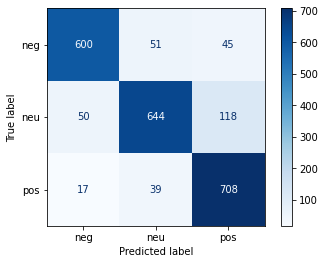

In [ ]:
import warnings
warnings.filterwarnings('ignore')

evaluation_report(y_val, y_predicted)

In [ ]:
index_word = {0: ""}
for w, i in word_index.items():
    index_word[i] = w

In [ ]:
def print_samples(samples_num, category_id):
    idxs = np.argmax(y_val, axis=1)==category_id
    for n in range(min(len(idxs), samples_num)):
        sent_num = x_val[idxs][n]
        # print(x_val[idxs][n])
        print(" ".join([index_word[sn] for sn in sent_num]))
        print("label:", y_val[idxs][n], "\tpredict:", np.round(y_predicted[idxs][n],3), "\n")

print_samples(5,0)
# print_samples(5,1)
print_samples(5,2)

bitcoin btc v pump save day price forced opposite direction supposed drop drop harder drop                         
label: [0.47444699 0.47139588 0.05415713] 	predict: [0.064 0.425 0.511] 

struggling imagine canadas worst bitcoin exchange look like                                
label: [0.56795422 0.32904149 0.10300429] 	predict: [0.477 0.438 0.085] 

bitcoin buy xrp                                     
label: [0.59451862 0.40548138 0.        ] 	predict: [0.561 0.439 0.   ] 

damn forget bitcoin look xrp                                   
label: [0.44479005 0.43468118 0.12052877] 	predict: [0.511 0.488 0.   ] 

destroys bitcoin one minor criticism                                   
label: [0.61878453 0.38121547 0.        ] 	predict: [0.665 0.261 0.074] 

laughing out loud house little value bought bitcoin                                
label: [0.         0.46412884 0.53587116] 	predict: [0.   0.35 0.65] 

love bitcoin                                      
label: [0.         0.327140

# TensorBoard

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir='/content/drive/MyDrive/CryptoSentimentAnalysis/logs'